In [3]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
class Preprocessing:
    def __init__(self):
        pass

    def get_data(self, data_path, features = None):
        df = pd.read_csv(data_path)
        
        if features:
            df = df[features]
            print(f'Data read from {data_path}')
        return df

    def clear_and_convert_cat_to_num(self, df, rows):
        pd.set_option('mode.chained_assignment',None)
    
    # Remove special characters at string form of numerical variables
        for row in rows:
            df[row] = df[row].str.replace(r'_+#F%$D@*&8', '')
        
    # String to numerical variables
        for row in rows:
            df[row] = pd.to_numeric(df[row], errors='coerce')
        return df


    def show_distribution(self, df, column):
        plt.figure(figsize=(12,8))
        sns.displot(data=df, x=df[column], kde=True, color="#1a659e")
        plt.show()
        
    def missing_values_diagnosys(self, df):
        columns_with_nan = df.columns[df.isnull().any()].tolist()
        if not columns_with_nan:
            print("There aren't variables with nan values")
        else:
            print(f"Variables with nan values are/is {columns_with_nan}")
            return columns_with_nan
        
        
    def resample_imputation(self, df, columns):
        for column in columns:
            fill_list = df[column].dropna().tolist()
            df[column] = df[column].fillna(pd.Series(np.random.choice(fill_list , size = len(df.index))))
        return df[column]

    def tukeys_method(self, df, variable):
        #Takes two parameters: dataframe & variable of interest as string
        q1 = df[variable].quantile(0.25)
        q3 = df[variable].quantile(0.75)
        iqr = q3-q1
        inner_fence = 1.5*iqr
        outer_fence = 3*iqr
    
        #inner fence lower and upper end
        inner_fence_le = q1-inner_fence
        inner_fence_ue = q3+inner_fence
    
        #outer fence lower and upper end
        outer_fence_le = q1-outer_fence
        outer_fence_ue = q3+outer_fence
    
        outliers_prob = []
        outliers_poss = []
        for index, x in enumerate(df[variable]):
            if x <= outer_fence_le or x >= outer_fence_ue:
                outliers_prob.append(index)
        for index, x in enumerate(df[variable]):
            if x <= inner_fence_le or x >= inner_fence_ue:
                outliers_poss.append(index)
            
        return outliers_prob, outliers_poss, outer_fence_ue,outer_fence_le        
    
    def tukey_execution(self, df, quantile_value = .95):
        
        # Checking the outliers using Tukey's method for all variables. 
        variables = df.select_dtypes([np.number]).columns
        for i in list(df[variables].columns.values):
    
            if df[i].isnull().sum() > 0:
                print(f"The column {i} has missing values. Skipping outlier treatment.")
                continue
    
            probable_outliers, possible_outliers,outer_fence_ue,outer_fence_le = pr.tukeys_method(df, i)
   
            print(f"The variable",i, "has ", len(possible_outliers),"possible and ",len(probable_outliers)," probable outliers.")
            # Keep only numerical variables
            for j in probable_outliers:
                df.loc[j,i] = df[i].quantile(.99)
        return df
    
    def OneClassSMV(self, df, nu= 0.01):
        
        # One - class SVM
        # evaluate model performance with outliers removed using one class SVM
        from sklearn.svm import OneClassSVM
        
         # Create a new dataframe with numerical columns    
        variables = df.select_dtypes([np.number]).columns

        df_num = df[variables]
        
        # split into input and output elements
        X, y = df_num.iloc[:, :-1], df_num.iloc[:, -1]

        # summarize the shape of the initial dataset
        print(r'The inital shape is',X.shape[0])

        # identify outliers in the dataset
        ee = OneClassSVM(nu=nu)
        yhat = ee.fit_predict(X)

        # select all rows that are not outliers
        mask = yhat != -1
        df_num = df_num.iloc[mask, :] 

        # summarize the shape of the updated training dataset
        print(r'The updated shape is',df_num.shape[0])
        
        # Rebiuld the initial dataframe    
        df_cat = df.drop(df_num.columns, axis =1)
        df = pd.concat([df_num, df_cat], axis=1, join='inner')
        
        return df
    
    def labelencoder(self, df):
        from sklearn.preprocessing import LabelEncoder as le                   

        catCols = df.select_dtypes([np.object]).columns
    
        for i in catCols:
            var_le = le()
            df[i] = var_le.fit_transform(df[i])
            
        return df
    
    def unbalancing_check_AND_handling(self, df):

        X, y = df.iloc[:, :-1], df.iloc[:, -1]

        y_vc = y.value_counts()
        
        print(y_vc)
    
        if abs(y_vc[0] - y_vc[1])/(y_vc[0] + y_vc[1]) >= 0.1:
            
            print(f"Target variable is unbalanced and we will use SMOTE")
            
            from imblearn.over_sampling import SMOTE
        
            smt = SMOTE(sampling_strategy='auto')
            
            X, y = smt.fit_resample(X, y)
            
            df = X.join(y)
        else:
            print("Difference between classes is lower than 10%, so could be assumed that target variable is balanced")
        
        return df
    
    def quasi_constant_duplicate_rowsANDcolumns(self, df):
        
        # Checking for constant features 
        from fast_ml.feature_selection import get_constant_features

        constant_features = get_constant_features(df)

        constant_features_list = constant_features.query("Desc=='Constant'")['Var'].to_list()
    
        if constant_features_list == []:
            print('There are not constant features')
        else:
            print(f"The constant features are {constant_features_list}")        
        
        # Dropping of constant features if they exist.
            print('Shape of Dataset before dropping the constant features: ', df.shape)
            df.drop(columns = constant_features_list, inplace=True)
            print('Shape of Dataset after dropping the constant features: ', df.shape)

        # Checking for quasi constant features.
        constant_features = get_constant_features(df, threshold=0.99, dropna=False)

        quasi_constant_features_list = constant_features.query("Desc=='Quasi Constant'")['Var'].to_list()
        if quasi_constant_features_list == []:
            print("There are not quasi constant features")
        else:
            print(f"The quasi constant features are {constant_features_list}")

        #To drop these quasi constant features from dataset

            print('Shape of Dataset before dropping the quasi constant features: ', df.shape)
            df.drop(columns = quasi_constant_features_list, inplace=True)
            print('Shape of Dataset after dropping the quasi constant features: ', df.shape)

        # Checking for duplicate columns
        duplicate_cols = df.columns[df.columns.duplicated()]
        if duplicate_cols.empty:
            print("There are not duplicate features")
        else:
            print(f"The list of duplicate features is {duplicate_cols} and drop them" )
        
            df.drop(columns=duplicate_cols, inplace=True)
    
        #Checking for dublicate rows 
        duplicate = df[df.duplicated()]
        if duplicate.empty:
            print("There are not duplicate rows")
        else:
            print(f"The list of duplicate rows is {duplicate} and drop them" )
        
            df.drop(duplicate.index, inplace=True)
 
        return df

    def correlation(self, df):
        plt.subplots(figsize=(15, 5))
        sns.heatmap(df.corr(), annot=True, cmap="RdYlGn")
        plt.show()
        
        # Use variance inflation factor to identify any significant multi-collinearity
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        
        def calc_vif(df):
            vif = pd.DataFrame()
            vif["variables"] = df.columns
            vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
            return(vif)
        
        variables = df.select_dtypes([np.number]).columns

        vif = calc_vif(df[variables])
        return vif 

### Dataset loading

In [5]:
data_path = r'C:\Users\...\credit_risk_dataset.csv'

pr = Preprocessing()

df = pr.get_data(data_path)

print(df.shape)
df.head()

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


## Feature Name	Description
person_age	    --->     Age

person_income	 --->     Annual Income

person_home_ownership	--->  Home ownership

person_emp_length	    ---->  Employment length (in years)

loan_intent	          ---->    Loan intent

loan_grade	     ---->    Loan grade

loan_amnt	     --->     Loan amount

loan_int_rate	      -->  Interest rate

loan_status	           --->    Loan status (0 is non default 1 is default)

loan_percent_income	    -->    Percent income

cb_person_default_on_file	-->   Historical default

cb_preson_cred_hist_length	-->   Credit history length

Through descriptive statistics, unsual values are detected. 

In [7]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


As it seems, dataset has some strange values, like maximum age 144. 

However, for a start, let's check if there are constant or duplicate columns an rows.

In [8]:
pr = Preprocessing()

# Monitoring of constant or duplicate instances and remove them
pr.quasi_constant_duplicate_rowsANDcolumns(df)

df.reset_index(inplace=True, drop=True)  #

df

There are not constant features
There are not quasi constant features
There are not duplicate features
The list of duplicate rows is        person_age  person_income person_home_ownership  person_emp_length  \
15975          23          42000                  RENT                5.0   
15989          23          90000              MORTGAGE                7.0   
15995          24          48000              MORTGAGE                4.0   
16025          24          10000                  RENT                8.0   
16028          23         100000              MORTGAGE                7.0   
...           ...            ...                   ...                ...   
32010          42          39996              MORTGAGE                2.0   
32047          36         250000                  RENT                2.0   
32172          49         120000              MORTGAGE               12.0   
32259          39          40000                   OWN                4.0   
32279          43   

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32411,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32412,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32413,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32414,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [9]:
df.shape

(32416, 12)

In [10]:
df['loan_status'] = df['loan_status'].astype(str)

## Missing values

In [11]:
# Checking the existance of nan.
columns_with_nan= pr.missing_values_diagnosys(df)

Variables with nan values are/is ['person_emp_length', 'loan_int_rate']


I will impute missing values with a resampling method which randomly assign values from variable's distribution.  

In [178]:
pr.resample_imputation(df,columns_with_nan)

df.reset_index(inplace=True, drop=True)  

# Verifing that missing values are replaced.
pr.missing_values_diagnosys(df)

There aren't variables with nan values


Unsual values is a kind of outliers and should be addressed by human reasoning. 

For example, if a person's age is entered incorrectly as 144 years old, it would be due to human error, and the actual age would be 44 years old.  

In [179]:
# Person_age has some obvious wrong valeus, that is 5 values are over 100.
print(df[df['person_age'] > 100].sum())

# We will tranfrm them to reasonale age for a human
if (df['person_age'] > 100).any():
    df.loc[df['person_age'] > 100, 'person_age'] -= 100

# Check results
print(f"Remain {df['person_age'].gt(100).sum()} unusual values.")

person_age                                                         678
person_income                                                  6608004
person_home_ownership                     RENTMORTGAGERENTRENTMORTGAGE
person_emp_length                                                 29.0
loan_intent                   VENTUREEDUCATIONEDUCATIONVENTUREPERSONAL
loan_grade                                                       CBBBC
loan_amnt                                                        56200
loan_int_rate                                                    53.83
loan_status                                                      00000
loan_percent_income                                               0.56
cb_person_default_on_file                                        NNNNN
cb_person_cred_hist_length                                          37
dtype: object
Remain 0 unusual values.


<Figure size 864x576 with 0 Axes>

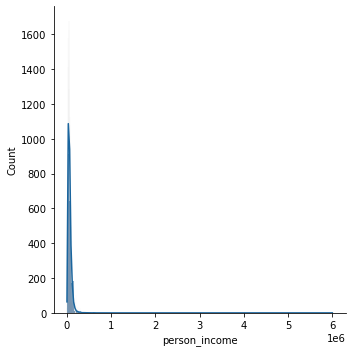

It is notable that the richest person has 6000000 dollars in annual income, while the person in the 99th quantile has 225000.0. So we cannot be too ambitious and exclude a rich person.


In [180]:
# Show distribution of person's income
pr.show_distribution(df,'person_income')

print(f"It is notable that the richest person has {df['person_income'].max()} dollars in annual income, while the person in the 99th quantile has {df['person_income'].quantile(.99)}. So we cannot be too ambitious and exclude a rich person.")

In [181]:
df['person_home_ownership'].value_counts()

print(f"{df['person_home_ownership'].value_counts()}. Variable person_home_ownership seems nice.")


RENT        16378
MORTGAGE    13369
OWN          2563
OTHER         106
Name: person_home_ownership, dtype: int64. Variable person_home_ownership seems nice.


In [182]:
# person_emp_length has some obvious wrong valeus, as legal employment could be from 15 years old.
print(df[df['person_emp_length'] > (df['person_age'] - 15)].sort_values('person_emp_length', ascending=False))

print("As we can see, three first rows are problematics. Hence, I modify them to more reasonable.")

# We will tranfrm them to reasonale age for a human
if (df['person_emp_length'] > (df['person_age'] - 15)).any():
    df.loc[df['person_emp_length'] > (df['person_age'] - 15), 'person_emp_length'] = df['person_age'] - 15
    
# Check results
print(f"Remain {df[df['person_emp_length'] > (df['person_age'] - 15)].sum().sum()} unusual values.")

       person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
210            21         192000              MORTGAGE              123.0   
10609          22          36000                  RENT               20.0   
2007           24          30000              MORTGAGE               20.0   
4857           22          36000                  RENT               20.0   
...           ...            ...                   ...                ...   
6480           22          50000              MORTGAGE                8.0   
8394           22          57600                   OWN                8.0   
11384          22          60000                  RENT                8.0   
965            21          36000                  RENT                7.0   
2172           21          12540                  RENT                7.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate loan_status  \


In [183]:
# loan_intent
df['loan_intent'].value_counts()

print(f"{df['loan_intent'].value_counts()}. Variable loan_intent seems nice.")

EDUCATION            6411
MEDICAL              6042
VENTURE              5682
PERSONAL             5498
DEBTCONSOLIDATION    5189
HOMEIMPROVEMENT      3594
Name: loan_intent, dtype: int64. Variable loan_intent seems nice.


In [184]:
# loan_grade
df['loan_grade'].value_counts()

print(f"{df['loan_grade'].value_counts()}. Variable loan_intent seems nice.")

A    10703
B    10387
C     6438
D     3620
E      963
F      241
G       64
Name: loan_grade, dtype: int64. Variable loan_intent seems nice.


<Figure size 864x576 with 0 Axes>

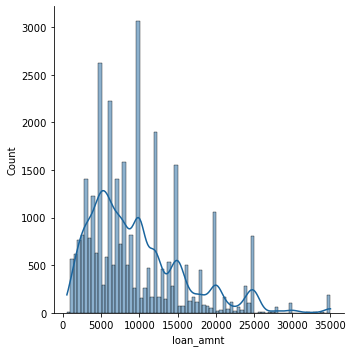

According to distribution, we do not notice something unusual.


In [185]:
# loan_amnt
# Show distribution of person's income
pr.show_distribution(df,'loan_amnt')

print('According to distribution, we do not notice something unusual.')

<Figure size 864x576 with 0 Axes>

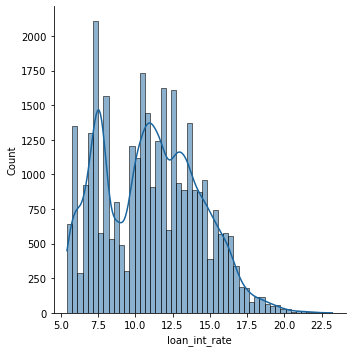

According to distribution, we do not notice something unusual.


In [186]:
# loan_int_rate
pr.show_distribution(df,'loan_int_rate')

print('According to distribution, we do not notice something unusual.')

In [187]:
# loan_status
df['loan_status'].value_counts()

print(f"{df['loan_status'].value_counts()}. Variable loan_status seems good, but it should be balanced because is target variable.")

0    25327
1     7089
Name: loan_status, dtype: int64. Variable loan_status seems good, but it should be balanced because is target variable.


<Figure size 864x576 with 0 Axes>

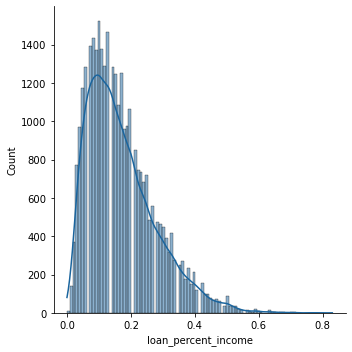

According to distribution, we do not notice something unusual.


In [188]:
# loan_percent_income
pr.show_distribution(df,'loan_percent_income')

print('According to distribution, we do not notice something unusual.')

In [189]:
# cb_person_default_on_file
df['cb_person_default_on_file'].value_counts()

print(f"{df['cb_person_default_on_file'].value_counts()}. Variable loan_intent seems nice.")

N    26686
Y     5730
Name: cb_person_default_on_file, dtype: int64. Variable loan_intent seems nice.


In [190]:
# cb_person_cred_hist_length
# cb_person_cred_hist_length should take into account that the youngest age for a loan is 16 years old (student loans).
print(f'Total unusual values are {df[df["cb_person_cred_hist_length"] > (df["person_age"] - 16)].sum().sum()}.')

Total unusual values are 0.0.


In [191]:
pr = Preprocessing()

# Outliers
# 1 Dimansion
pr.tukey_execution(df=df, quantile_value = .99)

The variable person_age has  1489 possible and  283  probable outliers.
The variable person_income has  1478 possible and  431  probable outliers.
The variable person_emp_length has  854 possible and  71  probable outliers.
The variable loan_amnt has  1679 possible and  189  probable outliers.
The variable loan_int_rate has  7 possible and  0  probable outliers.
The variable loan_percent_income has  650 possible and  26  probable outliers.
The variable cb_person_cred_hist_length has  1139 possible and  171  probable outliers.


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,7.0,PERSONAL,D,29800,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,29800,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,29800,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32411,50,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,17
32412,50,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32413,50,76000,RENT,3.0,HOMEIMPROVEMENT,B,29800,10.99,1,0.46,N,17
32414,50,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,17


In [192]:
df = pr.OneClassSMV(df, nu = 0.1)

df.reset_index(inplace=True, drop=True)  #

df

The inital shape is 32416
The updated shape is 29168


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership,loan_intent,loan_grade,loan_status,cb_person_default_on_file
0,23,120000,1.0,25600,12.69,0.21,3,RENT,EDUCATION,B,0,N
1,22,60000,0.0,25475,10.99,0.42,3,RENT,VENTURE,B,1,N
2,21,42500,3.0,25000,12.73,0.59,3,RENT,EDUCATION,C,1,Y
3,26,48000,2.0,25000,9.64,0.52,4,RENT,EDUCATION,B,1,N
4,25,42360,1.0,25000,16.35,0.59,3,RENT,EDUCATION,E,1,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
29163,50,64500,0.0,5000,11.26,0.08,20,RENT,EDUCATION,B,0,N
29164,50,53000,1.0,5800,13.16,0.11,17,MORTGAGE,PERSONAL,C,0,N
29165,50,120000,4.0,17625,7.49,0.15,19,MORTGAGE,PERSONAL,A,0,N
29166,50,150000,5.0,15000,11.48,0.10,17,MORTGAGE,PERSONAL,B,0,N


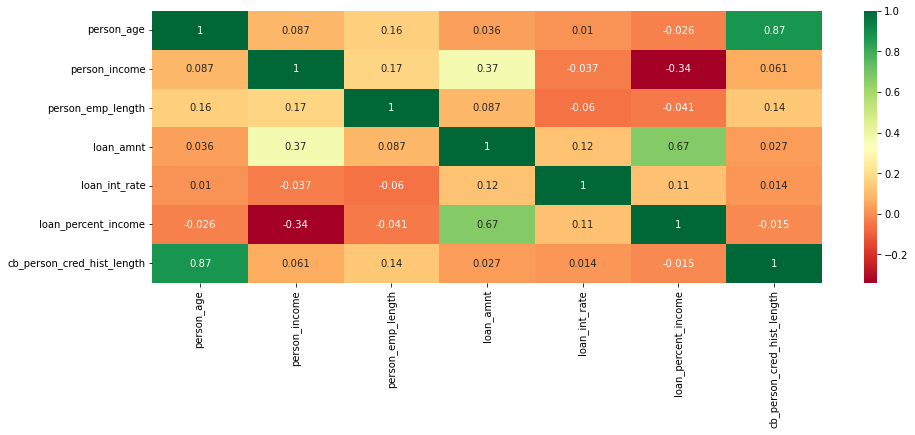

,variables,VIF
0,person_age,43.864245
1,person_income,18.660395
2,person_emp_length,2.622643
3,loan_amnt,21.245632
4,loan_int_rate,10.931649
5,loan_percent_income,18.699627
6,cb_person_cred_hist_length,8.871275


In [193]:
pr = Preprocessing()

pr.correlation(df)

In [194]:
# Encode categorical variables
pr.labelencoder(df)

df

C:\Users\User\AppData\Local\Temp\ipykernel_7424\87988617.py:126: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  catCols = df.select_dtypes([np.object]).columns


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership,loan_intent,loan_grade,loan_status,cb_person_default_on_file
0,23,120000,1.0,25600,12.69,0.21,3,3,1,1,0,0
1,22,60000,0.0,25475,10.99,0.42,3,3,5,1,1,0
2,21,42500,3.0,25000,12.73,0.59,3,3,1,2,1,1
3,26,48000,2.0,25000,9.64,0.52,4,3,1,1,1,0
4,25,42360,1.0,25000,16.35,0.59,3,3,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
29163,50,64500,0.0,5000,11.26,0.08,20,3,1,1,0,0
29164,50,53000,1.0,5800,13.16,0.11,17,0,4,2,0,0
29165,50,120000,4.0,17625,7.49,0.15,19,0,4,0,0,0
29166,50,150000,5.0,15000,11.48,0.10,17,0,4,1,0,0


In [195]:
# Pop up target variable to last column of data set.
col = df.pop('loan_status')
df.insert(len(df.columns), 'loan_status', col)

# Unbalacing monitoring
pr.unbalancing_check_AND_handling(df)

0    23267
1     5901
Name: loan_status, dtype: int64
Target variable is unbalanced and we will use SMOTE


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,loan_status
0,23,120000,1.000000,25600,12.690000,0.210000,3,3,1,1,0,0
1,22,60000,0.000000,25475,10.990000,0.420000,3,3,5,1,0,1
2,21,42500,3.000000,25000,12.730000,0.590000,3,3,1,2,1,1
3,26,48000,2.000000,25000,9.640000,0.520000,4,3,1,1,0,1
4,25,42360,1.000000,25000,16.350000,0.590000,3,3,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
46529,25,35000,9.314422,12892,7.015861,0.370000,2,3,3,1,0,1
46530,24,30000,2.000000,5213,17.301012,0.171388,4,3,0,4,0,1
46531,36,54000,20.923897,25000,15.575285,0.460000,15,0,0,3,0,1
46532,26,60000,0.000000,5000,10.823458,0.080000,5,1,3,1,0,1


In [196]:
# Create a dataframe with unseen data for testing model's accuracy
df_testing  = df.sample(frac = 0.2)

# Rest of them will be used for training the models
df_training = df.drop(df_testing.index[:])

# Save the clean dataset

df_training.to_csv(r'C:\Users\...\credit_risk_dataset_cleanedtraining.csv', index=False)

df_testing.to_csv(r'C:\Users\....\credit_risk_dataset_cleanedtesting.csv', index=False)
